# Communication in Crisis

## Acquire
Data: [Los Angeles Parking Citations](https://www.kaggle.com/cityofLA/los-angeles-parking-citations)<br>
Load the dataset and filter for:
- Citations issued from 2017-01-01 to 2021-04-12.
- Street Sweeping violations - `Violation Description` == __"NO PARK/STREET CLEAN"__

Let's acquire the parking citations data from our file.
1. Import libraries.
1. Load the dataset.
1. Display the shape and first/last 2 rows.
1. Display general infomation about the dataset - w/ the # of unique values in each column.
1. Display the number of missing values in each column.
1. Descriptive statistics for all numeric features.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
import time
import folium.plugins as plugins
from IPython.display import HTML
import json
import datetime
import calplot
import folium
import math
sns.set()

from tqdm.notebook import tqdm

import src

# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Load the data
df = src.get_sweep_data()

In [3]:
# Display the shape and dtypes of each column
print(df.shape)
df.info()

(2331357, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331357 entries, 0 to 2331356
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Ticket number           object 
 1   Issue Date              object 
 2   Issue time              float64
 3   Meter Id                object 
 4   Marked Time             float64
 5   RP State Plate          object 
 6   Plate Expiry Date       float64
 7   VIN                     float64
 8   Make                    object 
 9   Body Style              object 
 10  Color                   object 
 11  Location                object 
 12  Route                   object 
 13  Agency                  float64
 14  Violation code          object 
 15  Violation Description   object 
 16  Fine amount             float64
 17  Latitude                float64
 18  Longitude               float64
 19  Agency Description      object 
 20  Color Description       object 
 21  Body Style Descri

In [4]:
# Display the first two citations
df.head(2)

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,...,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Agency Description,Color Description,Body Style Description
0,4343388033,2018-10-25T00:00:00.000,1204.0,NaN,NaN,CA,201802.0,NaN,MNNI,PA,...,00472,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.477238e+06,1.854036e+06,NaN,NaN,NaN
1,4343388055,2018-10-25T00:00:00.000,1211.0,NaN,NaN,CA,201902.0,NaN,TOYT,PA,...,00472,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.477999e+06,1.851994e+06,NaN,NaN,NaN


In [5]:
# Display the last two citations
df.tail(2)

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,...,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Agency Description,Color Description,Body Style Description
2331355,4528743133,2021-04-12T00:00:00.000,1321.0,NaN,NaN,CA,202202.0,NaN,HOND,PA,...,00146,51.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.453129e+06,1.841444e+06,51 - DOT - WESTERN,GREY,PASSENGER CAR
2331356,4528737662,2021-04-12T00:00:00.000,1334.0,NaN,NaN,CA,202003.0,NaN,CHEV,PA,...,00500,55.0,80.69BS,NO PARK/STREET CLEAN,73.0,9.999900e+04,9.999900e+04,55 - DOT - SOUTHERN,BLUE,PASSENGER CAR


In [6]:
# Display descriptive statistics of numeric columns
df.describe()

,Issue time,Marked Time,Plate Expiry Date,VIN,Agency,Fine amount,Latitude,Longitude
count,2.331319e+06,0.0,2.127603e+06,0.0,2.331357e+06,2.331356e+06,2.331357e+06,2.331357e+06
mean,1.014283e+03,NaN,1.935550e+05,NaN,5.340632e+01,7.299999e+01,5.958707e+06,1.712558e+06
std,1.845180e+02,NaN,4.017076e+04,NaN,1.964918e+00,2.271562e-02,1.701745e+06,4.693699e+05
min,5.000000e+00,NaN,1.000000e+00,NaN,1.000000e+00,5.300000e+01,9.999900e+04,9.999900e+04
25%,8.430000e+02,NaN,2.018030e+05,NaN,5.100000e+01,7.300000e+01,6.425027e+06,1.825601e+06
50%,1.018000e+03,NaN,2.019030e+05,NaN,5.400000e+01,7.300000e+01,6.453423e+06,1.843862e+06
75%,1.208000e+03,NaN,2.020030e+05,NaN,5.500000e+01,7.300000e+01,6.472952e+06,1.859722e+06
max,2.355000e+03,NaN,9.201020e+05,NaN,5.800000e+01,9.300000e+01,6.513052e+06,1.940426e+06


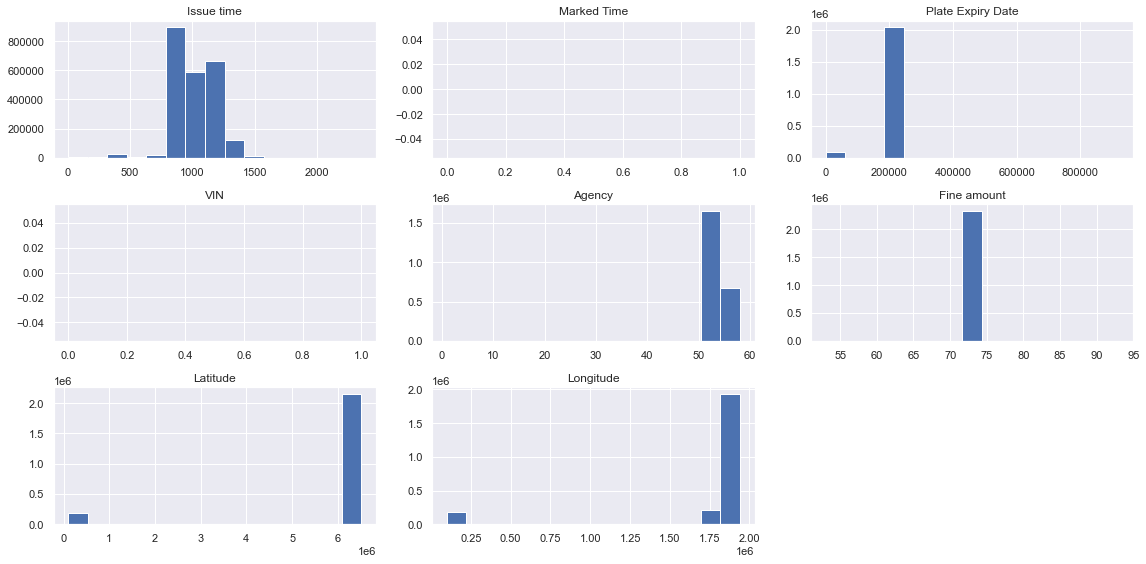

In [7]:
df.hist(figsize=(16, 8), bins=15)
plt.tight_layout();

__Initial findings__
- `Issue time` and `Marked Time` are quasi-normally distributed. Note: Poisson Distribution
- It's interesting to see the distribution of our activity on earth follows a normal distribution.
- Agencies 50+ write the most parking citations.
- Most fine amounts are less than $100.00
- There are a few null or invalid license plates.

# Prepare

- Remove spaces + capitalization from each column name.
- Cast `Plate Expiry Date` to datetime data type.
- Cast `Issue Date` and `Issue Time` to datetime data types.
- Drop columns missing >=74.42\% of their values. 
- Drop missing values.
- Transform Latitude and Longitude columns from NAD1983StatePlaneCaliforniaVFIPS0405 feet projection to EPSG:4326 World Geodetic System 1984: used in GPS [Standard]
- Filter data for street sweeping citations only.

In [8]:
# Prepare the data using a function stored in prepare.py
df_citations = src.prep_sweep_data(df)

# Display the first two rows
df_citations.head(2)

,issue_date,issue_time,rp_state_plate,plate_expiry_date,make,body_style,color,location,route,agency,violation_description,fine_amount,latitude,longitude,day_of_week,issue_year,issue_hour,issue_minute
0,2017-01-03 00:00:00,1900-01-01 12:18:00,CA,2017-12-01 00:00:00,NISS,PA,WT,508 GARDNER ST N,00472,54,NO PARK/STREET CLEAN,73.0,34.0804,-118.3532,Tuesday,2017,12,18
1,2017-01-03 00:00:00,1900-01-01 08:38:00,CA,2017-05-01 00:00:00,CHEV,PA,BK,400 LE DOUX ROAD,00472,54,NO PARK/STREET CLEAN,73.0,34.0719,-118.3774,Tuesday,2017,8,38


In [9]:
# Check the column data types and non-null counts.
df_citations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036169 entries, 0 to 2036168
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   issue_date             object 
 1   issue_time             object 
 2   rp_state_plate         object 
 3   plate_expiry_date      object 
 4   make                   object 
 5   body_style             object 
 6   color                  object 
 7   location               object 
 8   route                  object 
 9   agency                 int64  
 10  violation_description  object 
 11  fine_amount            float64
 12  latitude               float64
 13  longitude              float64
 14  day_of_week            object 
 15  issue_year             int64  
 16  issue_hour             int64  
 17  issue_minute           int64  
dtypes: float64(3), int64(4), object(11)
memory usage: 279.6+ MB


# Exploration

## How much daily revenue is generated from street sweeper citations?
### Daily Revenue from Street Sweeper Citations
Daily street sweeper citations increased in 2020.

In [10]:
# Daily street sweeping citation revenue
daily_revenue = df_citations.groupby('issue_date').fine_amount.sum()
daily_revenue.index = pd.to_datetime(daily_revenue.index)

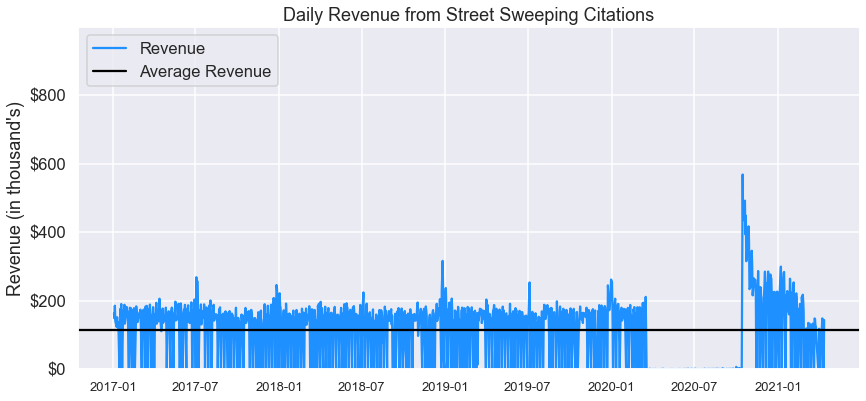

In [11]:
sns.set_context('talk')

# Plot daily revenue from street sweeping citations
daily_revenue.plot(figsize=(14, 7), label='Revenue', color='DodgerBlue')
plt.axhline(daily_revenue.mean(), color='black', label='Average Revenue')

plt.title("Daily Revenue from Street Sweeping Citations")
plt.xlabel('')
plt.ylabel("Revenue (in thousand's)")

plt.xticks(rotation=0, horizontalalignment='center', fontsize=13)
plt.yticks(range(0, 1_000_000, 200_000), ['$0', '$200', '$400', '$600', '$800',])
plt.ylim(0, 1_000_000)

plt.legend(loc=2, framealpha=.8);

### Anomaly: Declaration of Local Emergency

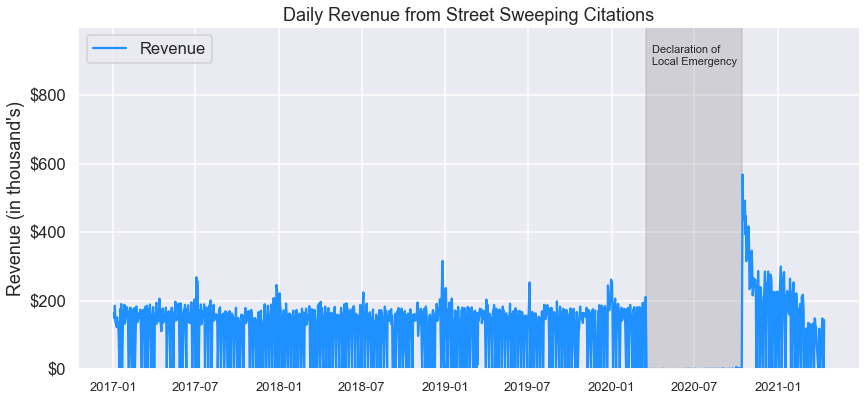

In [12]:
sns.set_context('talk')

# Plot daily revenue from street sweeping citations
daily_revenue.plot(figsize=(14, 7), label='Revenue', color='DodgerBlue')
plt.axvspan('2020-03-16', '2020-10-14', color='grey', alpha=.25)
plt.text('2020-03-29', 890_000, 'Declaration of\nLocal Emergency', fontsize=11)


plt.title("Daily Revenue from Street Sweeping Citations")
plt.xlabel('')
plt.ylabel("Revenue (in thousand's)")

plt.xticks(rotation=0, horizontalalignment='center', fontsize=13)
plt.yticks(range(0, 1_000_000, 200_000), ['$0', '$200', '$400', '$600', '$800',])
plt.ylim(0, 1_000_000)

plt.legend(loc=2, framealpha=.8);

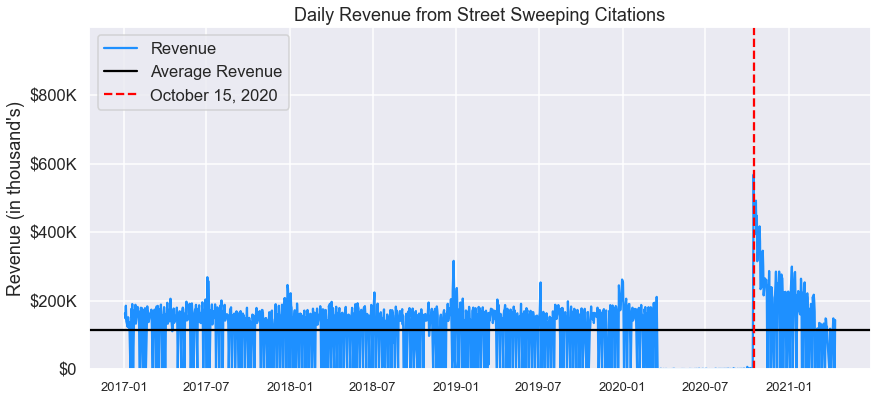

In [13]:
sns.set_context('talk')

# Plot daily revenue from street sweeping citations
daily_revenue.plot(figsize=(14, 7), label='Revenue', color='DodgerBlue')
plt.axhline(daily_revenue.mean(), color='black', label='Average Revenue')
plt.axvline(datetime.datetime(2020, 10, 15), color='red', linestyle="--", label='October 15, 2020')

plt.title("Daily Revenue from Street Sweeping Citations")
plt.xlabel('')
plt.ylabel("Revenue (in thousand's)")

plt.xticks(rotation=0, horizontalalignment='center', fontsize=13)
plt.yticks(range(0, 1_000_000, 200_000), ['$0', '$200K', '$400K', '$600K', '$800K',])
plt.ylim(0, 1_000_000)

plt.legend(loc=2, framealpha=.8);

In [10]:
## Add section comparing citation time distributions before and after parking was enforced.

# Results